In [19]:
import numpy as np
from sklearn.datasets import fetch_openml

In [3]:
mnist = fetch_openml("mnist_784", version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [6]:
print(mnist["DESCR"])

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [5]:
X, y = mnist["data"], mnist["target"]
X.shape, y.shape

((70000, 784), (70000,))

In [7]:
# Each image is 28px x 28px, resulting in 784 features.

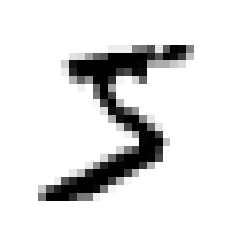

In [16]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X.iloc[0].values
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap="binary")
_ = plt.axis("off")

In [17]:
# What does the label tells us about the image above?
y[0]

'5'

In [21]:
# The label is a string. Cast them to integer.
y = y.astype(np.uint8)
y.dtypes

dtype('uint8')

In [22]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a binary classifier

In [23]:
y_train_5 = y_train == 5  # True for all 5, false for other digits
y_test_5 = y_test == 5

In [24]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

## Performance measure

In [31]:
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds, y_train_folds = X_train.iloc[train_index], y_train_5[train_index]
    X_test_folds, y_test_folds = X_train.iloc[test_index], y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [33]:
from sklearn.model_selection import cross_val_score

# help(cross_val_score)
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [52]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="constant", constant=0)
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

In [47]:
from sklearn.base import BaseEstimator


class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self

    def predict(self, X):
        return np.zeros((len(X), 1), dtype="bool")

In [48]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

## Confusion Matrix

In [66]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [59]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred, normalize=None)

array([[53892,   687],
       [ 1891,  3530]])

In [60]:
# Perfect classifier
y_train_perfect_prediction = y_train_5

confusion_matrix(y_train_5, y_train_perfect_prediction)

array([[54579,     0],
       [    0,  5421]])

## Precision and Recall

In [67]:
from sklearn.metrics import classification_report

print(classification_report(y_train_5, y_train_pred))

              precision    recall  f1-score   support

       False       0.97      0.99      0.98     54579
        True       0.84      0.65      0.73      5421

    accuracy                           0.96     60000
   macro avg       0.90      0.82      0.85     60000
weighted avg       0.95      0.96      0.95     60000



In [68]:
y_scores = cross_val_predict(
    sgd_clf, X_train, y_train_5, cv=3, method="decision_function"
)

In [69]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [98]:
def plot_precision_recall_vs_thresholds(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
    plt.set_xlabel = "Threshold"
    plt.axvline(8000, ymin=0, ymax=1, color="r", linestyle="--", linewidth=1)
    plt.grid()
    plt.legend()

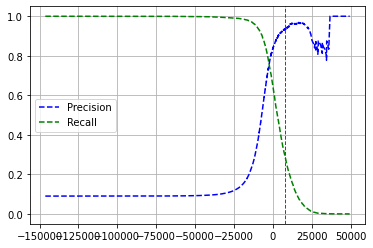

In [99]:
plot_precision_recall_vs_thresholds(precisions, recalls, thresholds)

In [126]:
def plot_precision_vs_recall(precisions, recalls):
    i = np.argmax(precisions >= 0.90)
    max_precision = precisions[i]
    max_recall = recalls[i]
    plt.plot(
        recalls,
        precisions,
    )
    plt.axvline(max_recall, 0, max_precision, color="r", linewidth=1, linestyle="--")
    plt.axhline(max_precision, 0, max_recall, color="r", linewidth=1, linestyle="--")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid()

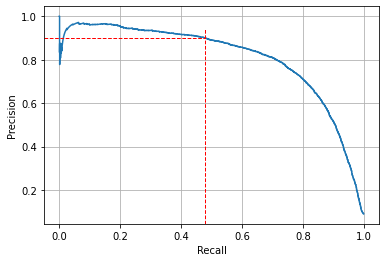

In [127]:
plot_precision_vs_recall(precisions, recalls)

In [128]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.019499143958

In [130]:
y_train_pred_90 = y_scores >= threshold_90_precision

print(classification_report(y_train_5, y_train_pred_90))

              precision    recall  f1-score   support

       False       0.95      0.99      0.97     54579
        True       0.90      0.48      0.63      5421

    accuracy                           0.95     60000
   macro avg       0.93      0.74      0.80     60000
weighted avg       0.95      0.95      0.94     60000



## The ROC Curve

In [131]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [134]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], "k--")  # Dashed diagonal
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.grid()

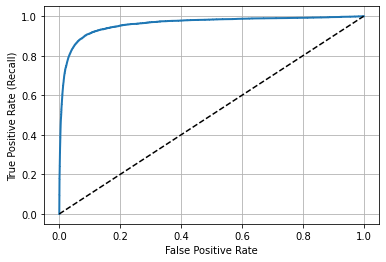

In [135]:
plot_roc_curve(fpr, tpr)

In [136]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [137]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(
    forest_clf, X_train, y_train_5, cv=3, method="predict_proba"
)

In [141]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

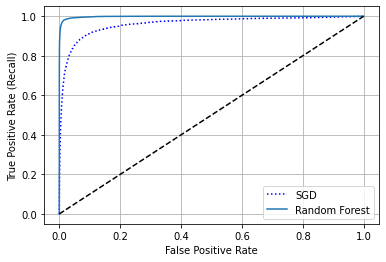

In [145]:
plt.plot(fpr, tpr, "b:", label="SGD")
plt.plot(fpr_forest, tpr_forest, label="Random Forest")
plt.plot([0, 1], [0, 1], "k--")  # Dashed diagonal
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.legend(loc="lower right")
plt.grid()

In [146]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

## Multiclass Classification

- binary classifier - distinguish between two classes
- multiclass classifier - distinguish between more than two classes (e.g. random forest, naive bayes, sgd)

In [159]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train.values, y_train)

SVC()

In [ ]:
some_digit = X_test.iloc[0]
svm_clf.predict([some_digit])

In [161]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 3.80895496, -0.30212376,  6.19343167,  8.29375992,  1.71167996,
         4.76436748,  0.69153837,  9.31783975,  2.75699419,  7.28292338]])

In [162]:
np.argmax(some_digit_scores)

7

In [163]:
svm_clf.classes_[7]

7

In [ ]:
# SVC uses OvO (One-versus-one) by default. To change it to OvR.
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train.values, y_train)

In [ ]:
ovr_clf.predict([some_digit])

In [ ]:
ovr_clf.estimators_

In [ ]:
sgd_clf.decision_function([some_digit])